In [642]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn 
import torch.optim as opt
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from torchmetrics import F1Score, AUROC, AveragePrecision, Accuracy


In [643]:
df=pd.read_csv("./processed_df.csv")
df=df.drop(columns=["Unnamed: 0"])

First we need to split our dataset into a train,validation, and test set. We will make the splits 70/15/15

In [644]:
X = df.drop(columns=["accepted"])
y = df["accepted"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Min/Max scale using min/max from our training set to avoid data leakage.

In [645]:
min,max=np.min(X_train,axis=0),np.max(X_train,axis=0)
X_train,X_val,X_test=((X_train-min)/(max-min)).values,((X_val-min)/(max-min)).values,(((X_test-min)/(max-min)).values)
y_train,y_val,y_test=y_train.values,y_val.values,y_test.values

Hyperparameter tuning for logistic regression and then we keep track of useful metrics 

In [199]:
C_values =[10**i for i in range(-3,5)]

best_C = None
best_f1 = 0
results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    f1_scores = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        model = LogisticRegression(C=C, class_weight='balanced', random_state=42)
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        f1 = f1_score(y_test_fold, y_pred_fold)
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)
    results.append((C, avg_f1))
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_C = C


In [200]:
log_reg_metrics_dict={}
final_model=LogisticRegression(C=best_C,class_weight="balanced",random_state=42)
final_model.fit(np.concatenate([X_train,X_val],axis=0),np.concatenate([y_train,y_val],axis=0))
probs=final_model.predict_proba(X_test)[:,1]
pred_labels=final_model.predict(X_test)
log_reg_metrics_dict["accuracy"]=np.mean(pred_labels==y_test)
log_reg_metrics_dict["f1_score"]=f1_score(y_test,pred_labels)
log_reg_metrics_dict["auc"]=roc_auc_score(y_test,probs)
log_reg_metrics_dict["pr-auc"]=average_precision_score(y_test,probs)
log_reg_metrics_dict["baseline_pos"]=y_test.mean()


We will now train a Tree Based Classifier(Random Forest) with our hyper-params to be the number of trees, max-depth and max-features to split on.

In [460]:
log_reg_metrics_dict

{'accuracy': 0.7256830601092896,
 'f1_score': 0.4176334106728538,
 'auc': 0.814980614732803,
 'pr-auc': 0.3546443625157215,
 'baseline_pos': 0.13879781420765028}

In [201]:
hyperparameter_grid = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'n_estimators': [50, 100, 200],
    'criterion': ['entropy'],
    'class_weight': ['balanced', 'balanced_subsample']
}
best_params = {}
best_f1 = 0
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for max_features in hyperparameter_grid['max_features']:
    for max_depth in hyperparameter_grid['max_depth']:
        for n_estimators in hyperparameter_grid['n_estimators']:
            for criterion in hyperparameter_grid['criterion']:
                for class_weight in hyperparameter_grid['class_weight']:
                    f1_scores = []
                    for train_index, test_index in skf.split(X_train, y_train):
                        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
                        model = RandomForestClassifier(
                            max_features=max_features,
                            max_depth=max_depth,
                            n_estimators=n_estimators,
                            criterion=criterion,
                            class_weight=class_weight,
                            random_state=42
                        )
                        model.fit(X_train_fold, y_train_fold)
                        y_pred_fold = model.predict(X_test_fold)
                        f1 = f1_score(y_test_fold, y_pred_fold)
                        f1_scores.append(f1)
                    avg_f1 = np.mean(f1_scores)
                    results.append({
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'n_estimators': n_estimators,
                        'criterion': criterion,
                        'class_weight': class_weight,
                        'f1_score': avg_f1
                    })
                    if avg_f1 > best_f1:
                        best_f1 = avg_f1
                        best_params = {
                            'max_features': max_features,
                            'max_depth': max_depth,
                            'n_estimators': n_estimators,
                            'criterion': criterion,
                            'class_weight': class_weight
                        }
best_params, best_f1



({'max_features': 'sqrt',
  'max_depth': 10,
  'n_estimators': 100,
  'criterion': 'entropy',
  'class_weight': 'balanced'},
 0.5168303838561632)

In [202]:
random_forest_metrics_dict={}
final_model=RandomForestClassifier(**best_params,random_state=42)
final_model.fit(np.concatenate([X_train,X_val],axis=0),np.concatenate([y_train,y_val],axis=0))
probs=final_model.predict_proba(X_test)[:,1]
pred_labels=final_model.predict(X_test)
random_forest_metrics_dict["accuracy"]=np.mean(pred_labels==y_test)
random_forest_metrics_dict["f1_score"]=f1_score(y_test,pred_labels)
random_forest_metrics_dict["auc"]=roc_auc_score(y_test,probs)
random_forest_metrics_dict["pr-auc"]=average_precision_score(y_test,probs)
random_forest_metrics_dict["baseline_pos"]=y_test.mean()

In [322]:
random_forest_metrics_dict

{'accuracy': 0.7617486338797814,
 'f1_score': 0.47596153846153844,
 'auc': 0.8493894640073544,
 'pr-auc': 0.3987473753488263,
 'baseline_pos': 0.13879781420765028}

Our final non-deep learning model will be KNN classifier. We test this because we might think that there when determining if a person might get accepted/rejected it is natural to look at how those who have a similiar profile to the person did to inform their own success.

In [203]:
hyperparameter_grid = {
    'n_neighbors': np.arange(3,15),
    'weights': ['uniform', 'distance']
}
best_params = {}
best_f1 = 0
results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_neighbors in hyperparameter_grid['n_neighbors']:
    for weights in hyperparameter_grid['weights']:
        f1_scores = []
        for train_index, test_index in skf.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_test_fold)
            f1 = f1_score(y_test_fold, y_pred_fold)
            f1_scores.append(f1)
        avg_f1 = np.mean(f1_scores)
        results.append({
            'n_neighbors': n_neighbors,
            'weights': weights,
            'f1_score': avg_f1
        })

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = {
                'n_neighbors': n_neighbors,
                'weights': weights
            }

best_params, best_f1

({'n_neighbors': 4, 'weights': 'distance'}, 0.25632740854001257)

In [204]:
knn_metrics_dict={}
final_model=KNeighborsClassifier(**best_params)
final_model.fit(np.concatenate([X_train,X_val],axis=0),np.concatenate([y_train,y_val],axis=0))
probs=final_model.predict_proba(X_test)[:,1]
pred_labels=final_model.predict(X_test)
knn_metrics_dict["accuracy"]=np.mean(pred_labels==y_test)
knn_metrics_dict["f1_score"]=f1_score(y_test,pred_labels)
knn_metrics_dict["auc"]=roc_auc_score(y_test,probs)
knn_metrics_dict["pr-auc"]=average_precision_score(y_test,probs)
knn_metrics_dict["baseline_pos"]=y_test.mean()

Now, we will train a simple Neural Network classifier with torch.

# Define our network using typical batchnorm and dropout.

In [646]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(27, 32),
            nn.BatchNorm1d(32),
            nn.ELU(alpha=1.0), 
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ELU(alpha=1.0), 
        )
        self.fc3 = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ELU(alpha=1.0), 
        )
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.fc4(x)

# Set up our datasets/loaders 

In [647]:
X_train = torch.tensor(X_train, dtype=torch.float32)  
y_train = torch.tensor(y_train, dtype=torch.float32)    
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




# Set up weighted loss function(optimization problem) and optimizer(Adam) and model

In [648]:
model=Classifier()
loss_fn=nn.BCEWithLogitsLoss(pos_weight=(len(y_train)-y_train.sum())/y_train.sum())   # Using pytorch docs pos_weight=num_negative/num_pos
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [649]:
def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    for i, (X, y) in enumerate(data_loader):
        # clear parameter gradients
        model.train()
        optimizer.zero_grad()
        y=y.reshape(-1,1)

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
def _evaluate_epoch(tr_loader, val_loader, model, criterion):
    """
    Evaluates the `model` on the train and validation set.
    """
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0, 0
    running_loss = []
    for X, y in tr_loader:
        with torch.no_grad():
            y=y.reshape(-1,1)
            output = model(X)
            predicted = (output>=0.0).long()
            y_true.append(y)
            y_pred.append(predicted)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            running_loss.append(criterion(output, y).item())
    train_loss = np.mean(running_loss)
    train_acc = correct / total
    y_true, y_pred = [], []
    correct, total = 0, 0
    running_loss = []
    for X, y in val_loader:
        with torch.no_grad():
            y=y.reshape(-1,1)
            output = model(X)
            predicted = (output>=0.0).long()
            y_true.append(y)
            y_pred.append(predicted)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            running_loss.append(criterion(output, y).item())
    val_loss = np.mean(running_loss)
    val_acc = correct / total
    return ([val_acc, val_loss, train_acc, train_loss])

# Let's train the model now!

In [650]:
results_dict={"val_acc":[],"val_loss":[],"train_acc":[],"train_loss":[]}
for epoch in range(50):
    _train_epoch(train_loader, model, loss_fn, optimizer)
    val_acc, val_loss, train_acc, train_loss=_evaluate_epoch(train_loader, val_loader, model, loss_fn)
    results_dict["val_acc"].append(val_acc)
    results_dict["val_loss"].append(val_loss)
    results_dict["train_acc"].append(train_acc)
    results_dict["train_loss"].append(train_loss)


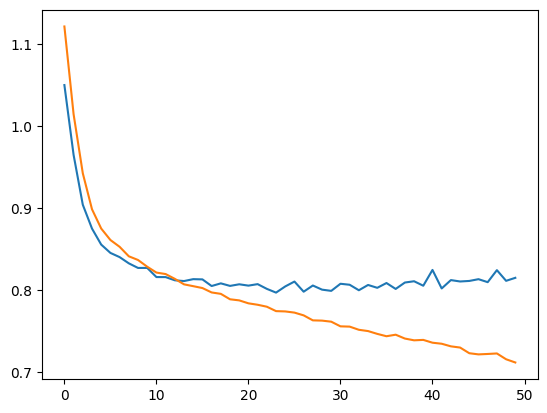

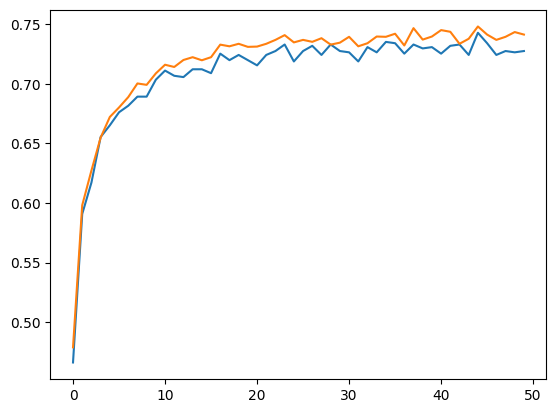

In [651]:
plt.plot(results_dict["val_loss"])
plt.plot(results_dict["train_loss"])
plt.show()
plt.plot(results_dict["val_acc"])
plt.plot(results_dict["train_acc"])

In [652]:
f1 = F1Score(task='binary')
auroc = AUROC(task='binary')
prauc = AveragePrecision(task='binary')
accuracy = Accuracy(task='binary')

with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    probs = torch.sigmoid(outputs)
    preds = (outputs >= 0).long()
    y_test_int = y_test.long()
    
    f1_score = f1(preds.reshape(-1), y_test_int)
    auc_score = auroc(probs.reshape(-1), y_test_int)
    prauc_score = prauc(probs.reshape(-1), y_test_int)
    acc_score = accuracy(preds.reshape(-1), y_test_int)

metrics_dict = {
    "accuracy": acc_score.item(),
    "f1_score": f1_score.item(),
    "auc": auc_score.item(),
    "pr-auc": prauc_score.item()
}

In [653]:
log_reg_metrics_dict

{'accuracy': 0.7256830601092896,
 'f1_score': 0.4176334106728538,
 'auc': 0.814980614732803,
 'pr-auc': 0.3546443625157215,
 'baseline_pos': 0.13879781420765028}

In [654]:
metrics_dict

{'accuracy': 0.7278688549995422,
 'f1_score': 0.4429530203342438,
 'auc': 0.7944262027740479,
 'pr-auc': 0.3444882035255432}